In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import paths

import importlib
import numpy as np
import xarray as xr
import scripts.basin_masks
import matplotlib.pyplot as plt

import ecco_v4_py as ecco

from streamfunction_ecco import streamfunction_ecco_utils as strf_ecco_utils
from streamfunction_ecco import streamfunction_custom_utils as strf_custom_utils

SETUP TO ACCESS THE VOLUME FLUX FILES 
1. Download 'Google Drive app' and login with your account that has access to GTC
2. Create a shortcut from the GTC folder in 'My Drive'
3. Go to File Explorer on your local computer (search for G:// or H:// ...) and navigate to the shortcut
4. Copy this filepath and replace it where it says 'DIR'

In [3]:
importlib.reload(paths)

<module 'paths' from 'C:\\Users\\aline\\OTP\\paths.py'>

In [4]:
# Load the data and the native geometry grid 
ecco_grid = xr.open_dataset(paths.geom_fp)

#nc_files = (os.path.join(paths.VELOCITY_NATIVE_GRID, '*.nc'))
nc_files = (os.path.join(paths.BOLUS_NATIVE_GRID, '*.nc'))
nc_ds = xr.open_mfdataset(nc_files, data_vars='minimal',coords='minimal',compat='override')

ds = xr.merge((nc_ds, ecco_grid))
ds

In [6]:
coords = strf_ecco_utils.parse_coords(ds, None, ["Z", "YC", "drF", "dyG", "dxG"])

# Compute volume transport
trsp_x = ds['UVELSTAR'] * coords["drF"] * coords["dyG"]
trsp_y = ds['VVELSTAR'] * coords["drF"] * coords["dxG"]

In [9]:
%%time
trsp_x = trsp_x.compute()
trsp_y = trsp_y.compute()

CPU times: total: 2min 46s
Wall time: 42min 37s


In [5]:
%%time
output_file = os.path.join(
            paths.STREAMFUNCTIONS_ECCO_OUTPUT,
            "transport_y_bolus.nc",
        )
trsp_y = xr.open_dataset(output_file)

CPU times: total: 0 ns
Wall time: 1.29 s


## CURRENTLY BEST WORKING METHOD
Using the latitudinal streamfunction function in ecco-package, customized to combine several basin masks together

In [53]:
%%time
importlib.reload(strf_ecco_utils)

latitude=-30

# Calculate streamfunction over 60S and over all time periods
PSI = strf_ecco_utils.calc_meridional_stf(ds, [latitude], doFlip = True, basin_name = ['pacExt', 'indExt'])

['pacExt', 'indExt']
get_basin_name:  ['pac', 'bering', 'okhotsk', 'japan', 'eastChina'] C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data
load_binary_array: loading file C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data\basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['pac', 'bering', 'okhotsk', 'japan', 'eastChina'] C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data
load_binary_array: loading file C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data\basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  

KeyboardInterrupt: 

In [64]:
# Save the streamfunction to the correct f
add = 'meridional_indo-pacific_'

output_file = os.path.join(paths.STREAMFUNCTIONS_ECCO_OUTPUT, 
                           f"{strf_custom_utils.format_lat_lon(latitude)}", 
                           f"PSI_{add}{strf_custom_utils.format_lat_lon(latitude)}.nc")
PSI.to_netcdf(output_file)

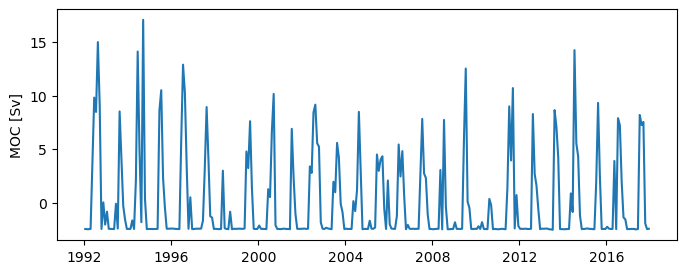

In [32]:
# Plot overturning streamfunction over time
plt.figure(figsize = (8, 3))
plt.plot(PSI.time, PSI.moc - PSI.moc.mean(dim = 'time'))

plt.ylabel('MOC [Sv]');

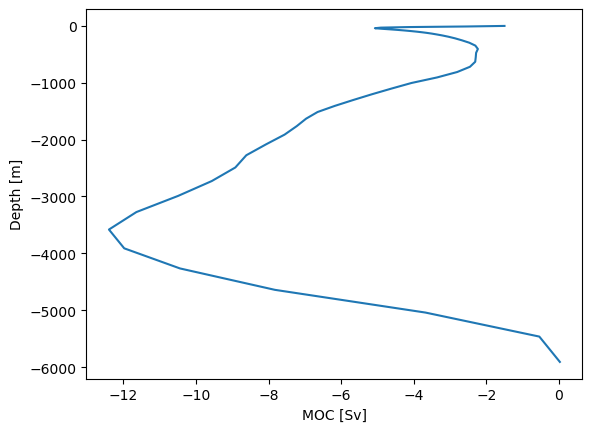

In [33]:
# Plot average streamfunction over depth space
plt.plot(PSI.psi_moc.mean(dim = 'time'), PSI.Z)

plt.xlabel('MOC [Sv]')
plt.ylabel('Depth [m]');

In [66]:
importlib.reload(strf_custom_utils)

<module 'streamfunction_ecco.streamfunction_custom_utils' from 'C:\\Users\\aline\\OTP\\streamfunction_ecco\\streamfunction_custom_utils.py'>

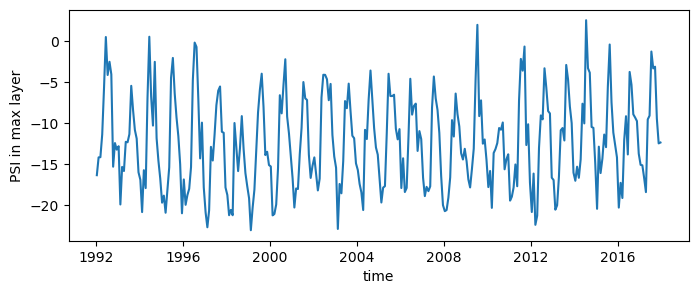

In [68]:
PSI_MAX_DENS = strf_custom_utils.get_PSI_at_max_density_level(PSI, max=True)

plt.figure(figsize = (8, 3))
plt.plot(PSI_MAX_DENS["time"], PSI_MAX_DENS["psi_moc"])

plt.xlabel('time')
plt.ylabel('PSI in max layer');

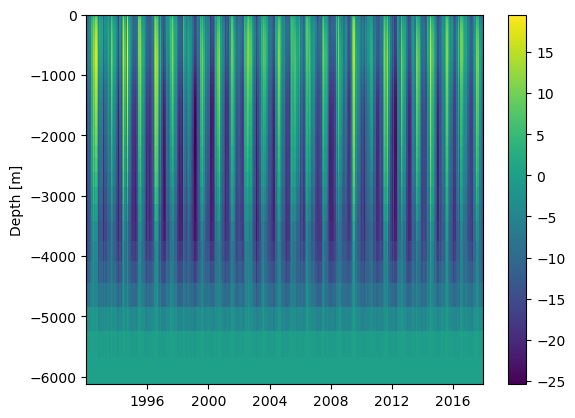

In [69]:
# Streamfunction over depth and time
plt.pcolormesh(PSI.time, PSI.Z, PSI.psi_moc.squeeze().T)
plt.colorbar()

plt.ylabel('Depth [m]');

### OLDER METHODS

#### 1. Tutorial from Ecco Website (streamfunction along section)

In [58]:
# Use this to define which latitude and longitudes we are working at 
basin = 'atlantic'
latitudes = basin_masks.get_lats_of_interest_solodoch(basin)

# Parameter 'latitude' and 'longitudes' will be used to create the masks
latitude = 26.5
longitudes = basin_masks.get_longitudes_at_latitude(latitude, basin, paths.geom_fp)

get_basin_name:  ['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents'] C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data
load_binary_array: loading file C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data\basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['med'] C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data
load_binary_array: loading file C:\Users\aline\mambaforge\envs\gtc\Lib\site-packages\binary_data\basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims

In [59]:
from functools import reduce

masks_W = []
masks_S = [] 
masks_C = []

longitude_sections = np.split(longitudes, np.where(np.diff(longitudes) > 1)[0] + 1)

for section in longitude_sections:
    maskC, maskW, maskS = ecco.get_section_line_masks([0, latitude],[90, latitude], ds)
    masks_C.append(maskC)
    masks_W.append(maskW)
    masks_S.append(maskS)
    
maskC_tot = reduce(lambda x, y: x | y, masks_C)
maskSedge = reduce(lambda x, y: x | y, masks_S)
maskWedge = reduce(lambda x, y: x | y, masks_W)

plt.figure(figsize=(12,6))
#ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,maskC_tot,cmap='viridis',projection_type='robin',user_lon_0=0);

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

### 2. Custom system to calculate the masks in the native grid

(array([0, 1]), array([105218,     82], dtype=int64))


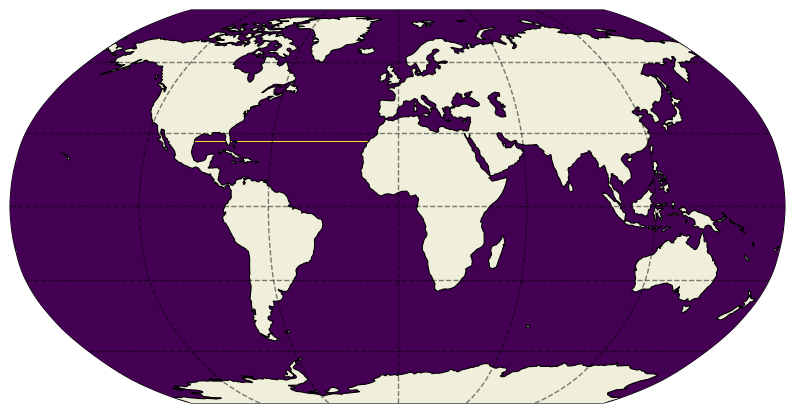

In [61]:
mask = strf_custom_utils.get_gridllc0090_mask(ds, latitude, longitudes)
print(np.unique(mask.values, return_counts=True))

plt.figure(figsize=(10,10))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,mask,cmap='viridis',projection_type='robin',user_lon_0=0);

#### 3. Implementation from scratch from Emilio

In [70]:
velocity = ds['VVELMASS'].isel(time = 0)
delta_x = ds['dxG']
delta_z = ds['drF']

weighted_velocity = velocity * delta_x * delta_z

In [71]:
mask = mask.rename({'j' : 'j_g'}) 
weighted_velocity_at_lat = mask * weighted_velocity

weighted_velocity_at_lat

<xarray.DataArray (tile: 13, j_g: 90, i: 90, k: 50)>
dask.array<multiply, shape=(13, 90, 90, 50), dtype=float64, chunksize=(13, 90, 90, 50), chunktype=numpy.ndarray>
Coordinates:
    YC       (tile, j_g, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    XC       (tile, j_g, i) float32 -111.6 -111.3 -110.9 ... -105.6 -111.9
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
    Z        (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-01-16T18:00:00

In [220]:
lon_by_depth = []

for i in range(13):    
    arr = weighted_velocity_at_lat.isel(tile = i).fillna(0).values
    nonzero_ind = np.nonzero(arr)

    unique_vals = np.unique(nonzero_ind[0]), np.unique(nonzero_ind[1])
    if len(unique_vals[0]) == 1:
        nonzero_vals = arr[unique_vals[0][0], : , : ]
    elif len(unique_vals[1]) == 1:
        nonzero_vals = arr[ : , unique_vals[1][0], : ]
    else:
        print('No nonzero vals')
        continue

    print(nonzero_vals.shape)
    lon_by_depth.append(nonzero_vals)

(90, 50)
No nonzero vals
No nonzero vals
(90, 50)
No nonzero vals
No nonzero vals
No nonzero vals
No nonzero vals
No nonzero vals
(90, 50)
No nonzero vals
No nonzero vals
(90, 50)


In [221]:
lon_by_depth = np.concatenate(lon_by_depth, axis = 0)
lon_by_depth.shape

(360, 50)

Streamfunction is -830 Sverdrups


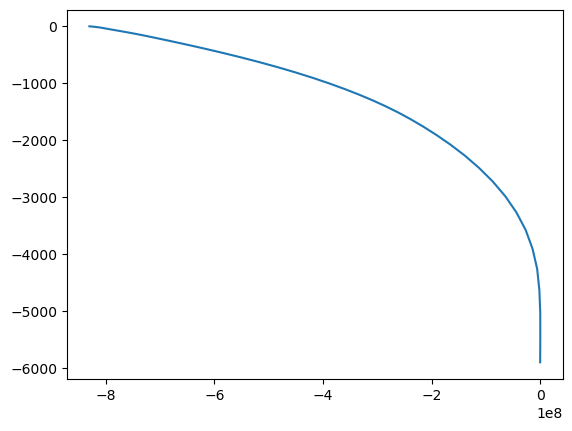

In [248]:
streamfunction = -1 * lon_by_depth.sum(axis = 0)[ : : -1].cumsum()
depth_level = np.abs(streamfunction).argmax()
print(f'Streamfunction is {round(streamfunction[depth_level] / (10 ** 6))} Sverdrups')

plt.plot(streamfunction, delta_z.Z[ : : -1]);

### Trying out janky function

In [9]:
from importlib import reload
reload(streamfunction)

<module 'streamfunction' from '/Users/emiliolr/Desktop/GTC-OTP/streamfunction.py'>

In [ ]:
strf_vals = []
for t in [i for i in range(10)]:
    strf_vals.append(streamfunction.calculate_streamfunction_JANKY(ds, basin = 'southern', latitude = -60, time = t, geom_fp = geom_fp))

In [12]:
strf_vals

[-830, -661, -696, -760, -687, -643, -811, -823, -819, -850]

### Strange stuff that isn't working...

In [70]:
# DO WE NEED TO SPLIT A maskWedge and maskSedge, if not, how to use the general mask? 

grid = ecco.ecco_utils.get_llc_grid(ds)
maskWedge = grid.diff(mask, 'X', boundary='fill')
maskSedge = grid.diff(mask, 'X', boundary='fill')
print(np.unique(maskWedge.values, return_counts=True))
print(np.unique(maskSedge.values, return_counts=True))

(array([-1,  0,  1]), array([   137, 105026,    137], dtype=int64))
(array([-1,  0,  1]), array([   137, 105026,    137], dtype=int64))


In [45]:
# Calculate volume transport in x and y direction
ds_out, sec_trsp_x, sec_trsp_y = volume_transport_calc(ds, maskS=maskSedge, maskW=maskWedge)

# Calculate total volume flux
ds_out["trsp_z"] = sec_trsp_y + sec_trsp_x

# Convert this to streamfunction
ds_out = calc_streamfunction_from_volume_transport(ds_out)
PSI = ds_out.compute()

MemoryError: Unable to allocate 6.35 GiB for an array with shape (1, 1, 13, 90, 90, 90, 90) and data type float64

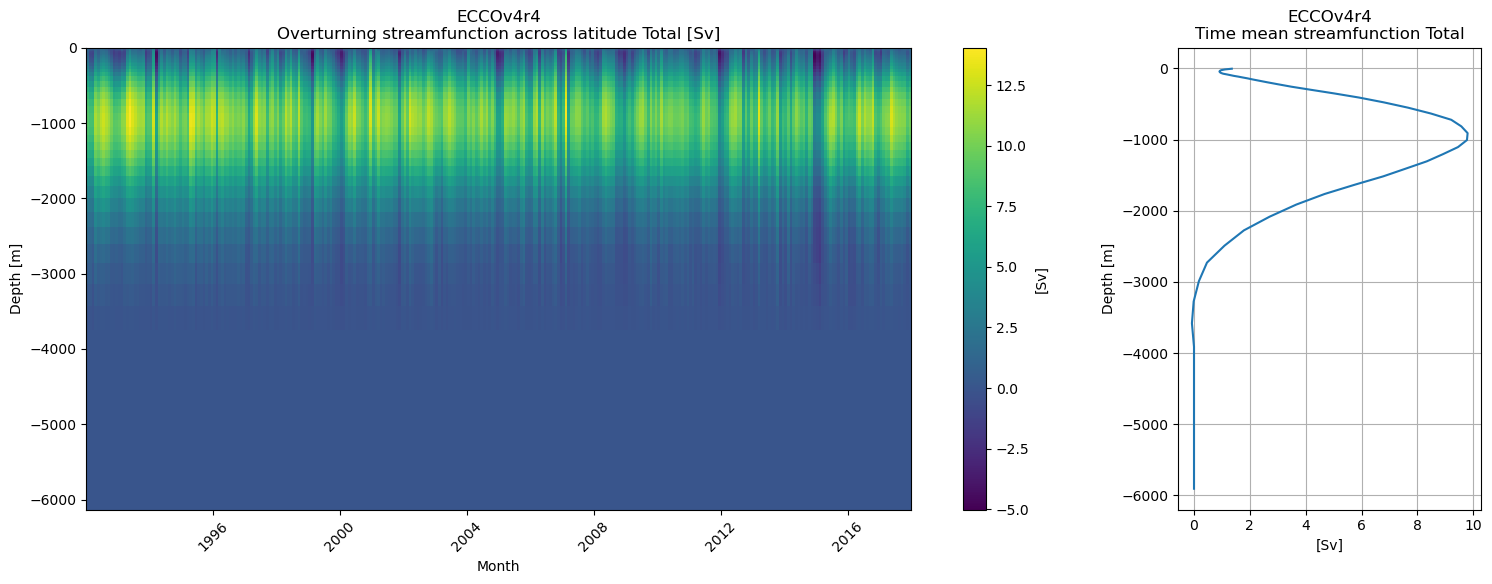

In [28]:
streamfunction.plot_depth_stf_vs_time(PSI,'Total', 'psi_moc')

## Open the output files so far to plot the streamfunctions

In [12]:
OUTPUT_DIR = paths.STREAMFUNCTIONS_ECCO_OUTPUT

PSI_26 = xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_residual26.5N.nc"))
PSI_30 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_residual30S.nc"))
PSI_60 = xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_residual60S.nc"))
PSI_55 = xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_residual55S.nc"))

PSI_bol_26 = xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_bolus26.5N.nc"))
PSI_bol_30 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_bolus30S.nc"))
PSI_bol_55 = xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_bolus55S.nc"))
PSI_bol_60 = xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_bolus60S.nc"))

In [13]:
def plot(PSI, PSI_bol=None):# Streamfunction over depth and time
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, (1, 3))
    plt.pcolormesh(PSI.time, PSI.Z, PSI.psi_moc.squeeze().T)
    if PSI_bol is not None:
        plt.pcolormesh(PSI.time, PSI.Z, PSI.psi_moc.squeeze().T+PSI_bol.psi_moc.squeeze().T)
    plt.colorbar()
    plt.ylabel('Depth [m]')
    
    plt.subplot(1, 4, 4)
    plt.plot(PSI['psi_moc'].mean("time"), PSI["Z"], 
             color='green', label='Residual Mean')
    if PSI_bol is not None:
        plt.plot(PSI_bol['psi_moc'].mean("time"), PSI_bol["Z"], 
                 linestyle='--', color='green', label='Bolus mean')
        plt.plot(PSI_bol['psi_moc'].mean("time")+PSI['psi_moc'].mean("time"), PSI_bol["Z"],
                 linestyle='-', color='blue', label='Sum mean')
    plt.ylabel("Depth [m]")
    plt.xlabel("[Sv]")
    plt.grid()
    plt.legend()
    plt.show()

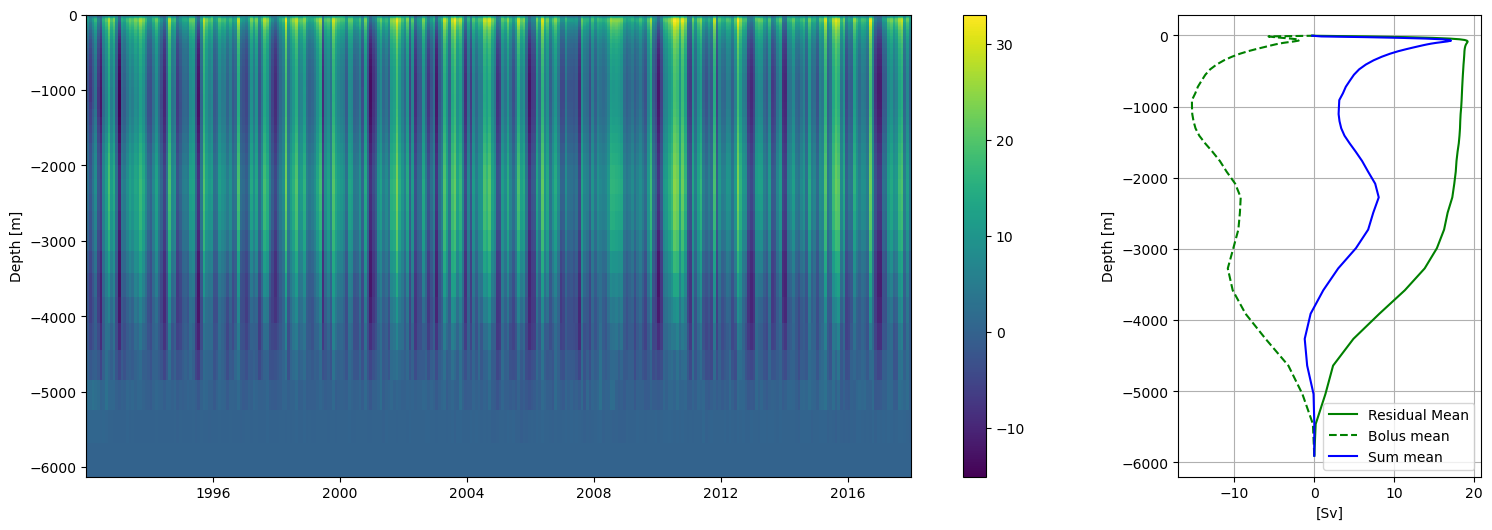

In [15]:
plot(PSI_60, PSI_bol_60)

In [16]:
PSI_MAX_DENS_26 = strf_custom_utils.get_PSI_at_max_density_level(PSI_26, max=False)
PSI_MAX_DENS_30 = strf_custom_utils.get_PSI_at_max_density_level(PSI_30, max=True)
PSI_MAX_DENS_55 = strf_custom_utils.get_PSI_at_max_density_level(PSI_55, max=True)
PSI_MAX_DENS_60 = strf_custom_utils.get_PSI_at_max_density_level(PSI_60, max=True)

PSI_MAX_DENS_BOL_26 = strf_custom_utils.get_PSI_at_max_density_level(PSI_bol_26, max=False)
PSI_MAX_DENS_BOL_30 = strf_custom_utils.get_PSI_at_max_density_level(PSI_bol_30, max=True)
PSI_MAX_DENS_BOL_55 = strf_custom_utils.get_PSI_at_max_density_level(PSI_bol_55, max=True)
PSI_MAX_DENS_BOL_60 = strf_custom_utils.get_PSI_at_max_density_level(PSI_bol_60, max=True)

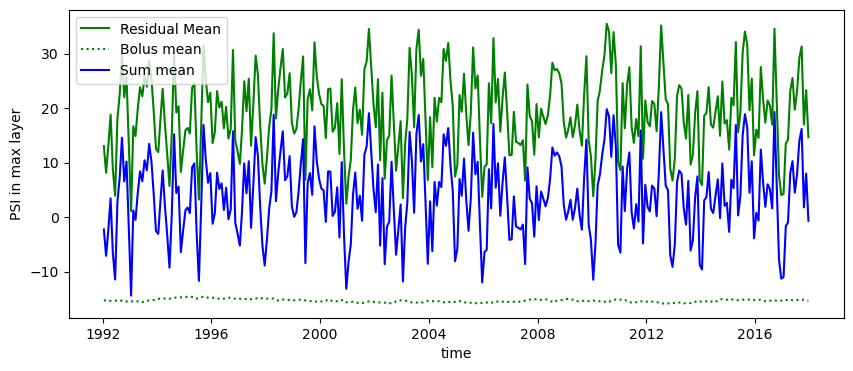

In [18]:
def plot_max_strf(psi_data, psi_data2=None):
    
    plt.figure(figsize = (10, 4))
    plt.plot(psi_data["time"], psi_data["psi_moc"],
             color='green', label='Residual Mean')
    
    if psi_data2 is not None:
        plt.plot(psi_data2["time"], psi_data2["psi_moc"], 
                 linestyle='dotted', color='green', label='Bolus mean')
        plt.plot(psi_data2["time"], psi_data["psi_moc"]+psi_data2["psi_moc"],
                 linestyle='-', color='blue', label='Sum mean')
        
    plt.xlabel('time')
    plt.ylabel('PSI in max layer')
    plt.legend()

plot_max_strf(PSI_MAX_DENS_60, PSI_MAX_DENS_BOL_60)